In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_again', 'X_train.npy'))
    labels = np.load(os.path.join('Data_again', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_again', 'X_test.npy'))
    labels = np.load(os.path.join('Data_again', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([3, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 0, 1, 3, 3, 0, 1, 1, 1, 2, 2, 2,
       1, 0, 0, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 1, 1, 3, 0, 3, 0, 0, 2,
       2, 3, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 3, 0, 2, 2, 2, 1, 3, 1, 0,
       2, 0, 3, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 1, 3, 0, 3, 3, 0, 0,
       3, 1, 0, 2, 2, 0, 2, 3, 3, 0, 2, 0, 0, 0, 0, 1, 1, 1, 3, 3, 1, 1,
       3, 3, 2, 0, 0, 0, 2, 3, 3, 0, 0, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 2, 2, 2, 1, 2, 2, 3, 0, 3, 1, 0, 0, 1, 0, 1, 2, 1, 3, 0,
       0, 3, 0, 1, 2, 2, 1, 0, 1, 3, 1, 3, 1, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 2, 2, 3, 3, 1, 1, 0, 1, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 1, 3,
       2, 0, 2, 2, 1, 3, 2, 2, 3, 2, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 0, 1,
       2, 3, 2, 1, 0, 3, 3, 0, 0, 0, 0, 1, 2, 1, 1, 3, 3, 3, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 3, 0, 0, 1, 0, 3, 2, 3, 2, 0, 2, 3, 0, 0, 0, 0, 0,
       3, 1, 2, 1, 0, 0, 3, 0, 1, 0, 2, 3, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0,
       3, 0, 3, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 3,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

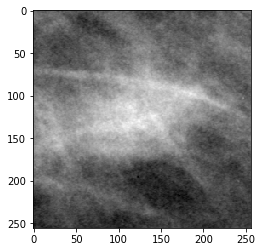

Label: [0. 0. 0. 1.]
[[[ 74.95703125  74.95703125  74.95703125]
  [ 71.01171875  71.01171875  71.01171875]
  [ 68.28515625  68.28515625  68.28515625]
  ...
  [ 81.6328125   81.6328125   81.6328125 ]
  [ 76.109375    76.109375    76.109375  ]
  [ 78.1015625   78.1015625   78.1015625 ]]

 [[ 75.8359375   75.8359375   75.8359375 ]
  [ 73.52734375  73.52734375  73.52734375]
  [ 70.09765625  70.09765625  70.09765625]
  ...
  [ 81.51171875  81.51171875  81.51171875]
  [ 78.08203125  78.08203125  78.08203125]
  [ 78.72265625  78.72265625  78.72265625]]

 [[ 74.5234375   74.5234375   74.5234375 ]
  [ 74.05859375  74.05859375  74.05859375]
  [ 69.05859375  69.05859375  69.05859375]
  ...
  [ 80.9296875   80.9296875   80.9296875 ]
  [ 80.99609375  80.99609375  80.99609375]
  [ 80.671875    80.671875    80.671875  ]]

 ...

 [[ 92.20703125  92.20703125  92.20703125]
  [ 91.7421875   91.7421875   91.7421875 ]
  [ 90.90625     90.90625     90.90625   ]
  ...
  [109.70703125 109.70703125 109.7070312

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 789

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

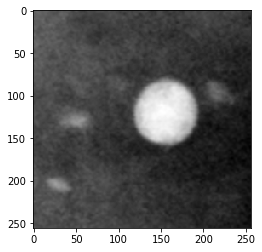

Label: [0. 0. 1. 0.]
[[[ 74.95703125  74.95703125  74.95703125]
  [ 71.01171875  71.01171875  71.01171875]
  [ 68.28515625  68.28515625  68.28515625]
  ...
  [ 81.6328125   81.6328125   81.6328125 ]
  [ 76.109375    76.109375    76.109375  ]
  [ 78.1015625   78.1015625   78.1015625 ]]

 [[ 75.8359375   75.8359375   75.8359375 ]
  [ 73.52734375  73.52734375  73.52734375]
  [ 70.09765625  70.09765625  70.09765625]
  ...
  [ 81.51171875  81.51171875  81.51171875]
  [ 78.08203125  78.08203125  78.08203125]
  [ 78.72265625  78.72265625  78.72265625]]

 [[ 74.5234375   74.5234375   74.5234375 ]
  [ 74.05859375  74.05859375  74.05859375]
  [ 69.05859375  69.05859375  69.05859375]
  ...
  [ 80.9296875   80.9296875   80.9296875 ]
  [ 80.99609375  80.99609375  80.99609375]
  [ 80.671875    80.671875    80.671875  ]]

 ...

 [[ 92.20703125  92.20703125  92.20703125]
  [ 91.7421875   91.7421875   91.7421875 ]
  [ 90.90625     90.90625     90.90625   ]
  ...
  [109.70703125 109.70703125 109.7070312

In [13]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 5

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))

print(train_images[0])

In [14]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [15]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 48,533,572
Trainable params: 33,818,884
Non-trainable params: 14,714,688
___________________________________

In [38]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128, output = 4)

In [39]:
vgg16_fe_drop_128.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
_________________________________

In [40]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [41]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.8441 - accuracy: 0.3859
Epoch 00001: val_loss improved from inf to 1.34328, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 23s 2s/step - loss: 2.7492 - accuracy: 0.3772 - val_loss: 1.3433 - val_accuracy: 0.4089
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3851 - accuracy: 0.4487
Epoch 00002: val_loss improved from 1.34328 to 1.20763, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.3597 - accuracy: 0.4529 - val_loss: 1.2076 - val_accuracy: 0.4759
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3333 - accuracy: 0.4750
Epoch 00003: val_loss improved from 1.20763 to 1.12939, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 1.3

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9020 - accuracy: 0.6125
Epoch 00057: val_loss did not improve from 0.93055
11/11 [==============================] - 22s 2s/step - loss: 0.8982 - accuracy: 0.6101 - val_loss: 0.9481 - val_accuracy: 0.5756
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8962 - accuracy: 0.5802
Epoch 00058: val_loss did not improve from 0.93055
11/11 [==============================] - 20s 2s/step - loss: 0.9042 - accuracy: 0.5800 - val_loss: 0.9557 - val_accuracy: 0.6031
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8869 - accuracy: 0.6297
Epoch 00059: val_loss did not improve from 0.93055
11/11 [==============================] - 22s 2s/step - loss: 0.8949 - accuracy: 0.6236 - val_loss: 0.9732 - val_accuracy: 0.5893
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9156 - accuracy: 0.6234
Epoch 00060: val_loss did not improve from 0.93055
11/11 [==================

Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8256 - accuracy: 0.6469
Epoch 00116: val_loss did not improve from 0.90356
11/11 [==============================] - 22s 2s/step - loss: 0.8218 - accuracy: 0.6506 - val_loss: 0.9335 - val_accuracy: 0.6014
Epoch 00116: early stopping


In [42]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [43]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [44]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [45]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 116
Epoch [opt]: 86
Valid accuracy [end]: 0.6014
Valid accuracy [opt]: 0.6031
Test accuracy [end]:  0.6168
Test accuracy [opt]:  0.6076
Valid loss [end]: 0.9335
Valid loss [opt]: 0.9036
Test loss [end]:  0.8817
Test loss [opt]:  0.8951


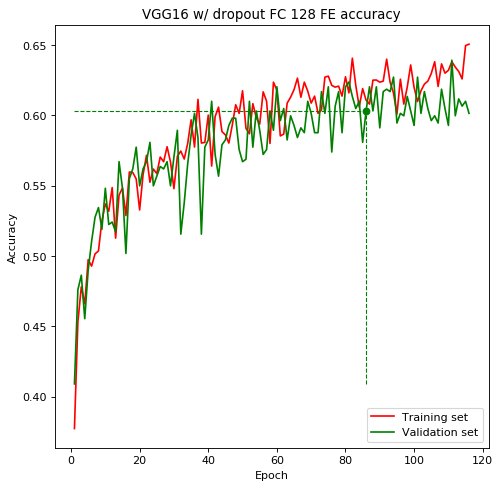

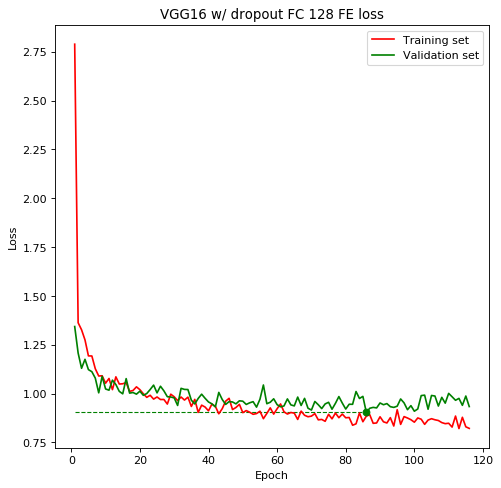

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [17]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256, output=4)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 2.9773 - accuracy: 0.2837
Epoch 00001: val_loss improved from inf to 1.61446, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 2.9392 - accuracy: 0.2857 - val_loss: 1.6145 - val_accuracy: 0.4141
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.9635 - accuracy: 0.3700
Epoch 00002: val_loss improved from 1.61446 to 1.48215, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.9565 - accuracy: 0.3689 - val_loss: 1.4821 - val_accuracy: 0.4175
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.8355 - accuracy: 0.3958
Epoch 00003: val_loss improved from 1.48215 to 1.39399, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.8

Epoch 27/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2140 - accuracy: 0.4880
Epoch 00027: val_loss improved from 1.04935 to 1.03939, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.2071 - accuracy: 0.4912 - val_loss: 1.0394 - val_accuracy: 0.5619
Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1961 - accuracy: 0.4902
Epoch 00028: val_loss did not improve from 1.03939
19/19 [==============================] - 29s 2s/step - loss: 1.2005 - accuracy: 0.4899 - val_loss: 1.0504 - val_accuracy: 0.5326
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1932 - accuracy: 0.4989
Epoch 00029: val_loss improved from 1.03939 to 1.02978, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1971 - accuracy: 0.4976 - val_loss: 1.0298 - val_accuracy: 0.5361
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 

Epoch 56/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1142 - accuracy: 0.5275
Epoch 00056: val_loss did not improve from 0.98638
19/19 [==============================] - 29s 2s/step - loss: 1.1114 - accuracy: 0.5260 - val_loss: 0.9866 - val_accuracy: 0.5567
Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1126 - accuracy: 0.5225
Epoch 00057: val_loss improved from 0.98638 to 0.98507, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1148 - accuracy: 0.5204 - val_loss: 0.9851 - val_accuracy: 0.5447
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1035 - accuracy: 0.5220
Epoch 00058: val_loss did not improve from 0.98507
19/19 [==============================] - 29s 2s/step - loss: 1.1024 - accuracy: 0.5225 - val_loss: 0.9894 - val_accuracy: 0.5636
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0856 - accuracy: 0.5266
Epoch 00059: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.0296 - accuracy: 0.5456
Epoch 00085: val_loss did not improve from 0.93928
19/19 [==============================] - 29s 2s/step - loss: 1.0357 - accuracy: 0.5401 - val_loss: 0.9668 - val_accuracy: 0.5859
Epoch 86/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0448 - accuracy: 0.5506
Epoch 00086: val_loss improved from 0.93928 to 0.93576, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.0417 - accuracy: 0.5517 - val_loss: 0.9358 - val_accuracy: 0.5876
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0278 - accuracy: 0.5397
Epoch 00087: val_loss did not improve from 0.93576
19/19 [==============================] - 29s 2s/step - loss: 1.0295 - accuracy: 0.5401 - val_loss: 0.9449 - val_accuracy: 0.5945
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0543 - accuracy: 0.5429
Epoch 00088: val_loss did not improve 

Epoch 114/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0232 - accuracy: 0.5465
Epoch 00114: val_loss did not improve from 0.89914
19/19 [==============================] - 29s 2s/step - loss: 1.0172 - accuracy: 0.5483 - val_loss: 0.9368 - val_accuracy: 0.5962
Epoch 115/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0157 - accuracy: 0.5520
Epoch 00115: val_loss did not improve from 0.89914
19/19 [==============================] - 29s 2s/step - loss: 1.0184 - accuracy: 0.5500 - val_loss: 0.9497 - val_accuracy: 0.5601
Epoch 116/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0162 - accuracy: 0.5674
Epoch 00116: val_loss improved from 0.89914 to 0.89558, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.0147 - accuracy: 0.5693 - val_loss: 0.8956 - val_accuracy: 0.6100
Epoch 117/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0259 - accuracy: 0.5592
Epoch 00117: val_loss

18/19 [===========================>..] - ETA: 1s - loss: 0.9749 - accuracy: 0.5651
Epoch 00143: val_loss did not improve from 0.88415
19/19 [==============================] - 29s 2s/step - loss: 0.9770 - accuracy: 0.5659 - val_loss: 0.9232 - val_accuracy: 0.6117
Epoch 144/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9644 - accuracy: 0.5679
Epoch 00144: val_loss did not improve from 0.88415
19/19 [==============================] - 29s 2s/step - loss: 0.9680 - accuracy: 0.5654 - val_loss: 0.8978 - val_accuracy: 0.6203
Epoch 145/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9820 - accuracy: 0.5774
Epoch 00145: val_loss did not improve from 0.88415
19/19 [==============================] - 29s 2s/step - loss: 0.9792 - accuracy: 0.5809 - val_loss: 0.9267 - val_accuracy: 0.5808
Epoch 146/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9961 - accuracy: 0.5601
Epoch 00146: val_loss did not improve from 0.88415
19/19 [============================

In [19]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [20]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 150
Epoch [opt]: 120
Valid accuracy [end]: 0.5859
Valid accuracy [opt]: 0.6186
Test accuracy [end]:  0.5893
Test accuracy [opt]:  0.5832
Valid loss [end]: 0.9222
Valid loss [opt]: 0.8842
Test loss [end]:  0.9372
Test loss [opt]:  0.9590


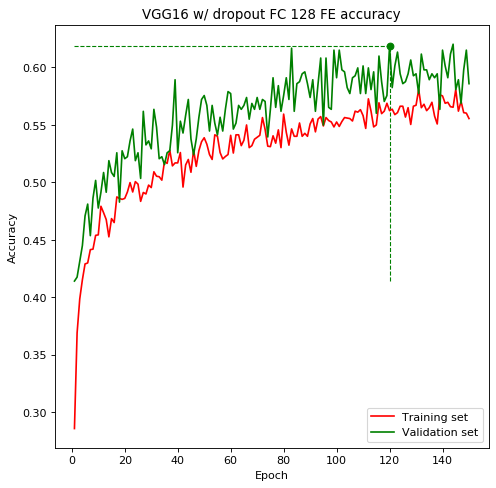

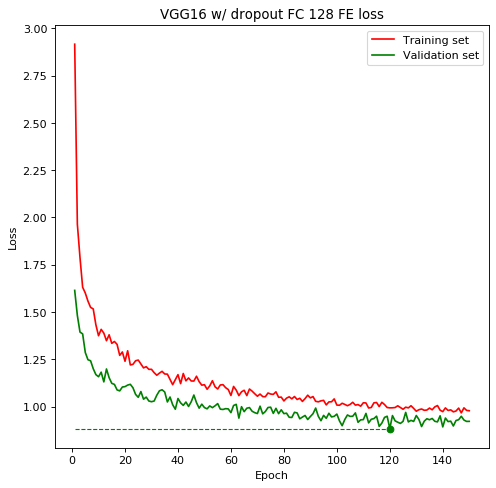

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [23]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
_________________________________

In [24]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 36,046,980
Non-trainable params: 12,354,880
_________________________________

In [25]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [26]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
 1/11 [=>............................] - ETA: 2:12WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ResourceExhaustedError:  OOM when allocating tensor with shape[128,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_3/vgg16/block1_conv2/Conv2D (defined at <ipython-input-26-1c160f47ea84>:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_26189]

Function call stack:
distributed_function


In [ ]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [ ]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [ ]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();